## Special Topics - Deep Learning Applications

#### Prof. Thomas da Silva Paula

### SSD demo

* Using Faster R-CNN with Inception backbone, trained on MSCOCO, from Tensorflow Object Detection API (https://github.com/tensorflow/models/tree/master/research/object_detection)
* Simplified version of original Tensorflow demonstration

### Imports

In [3]:
import cv2
import sys
import json
import pprint

import numpy as np
from PIL import Image

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches


plt.rcParams['figure.figsize'] = [14, 10]

### Useful methods

In [2]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_to_nparray(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def load_coco_dict(labels_path):
    with open(labels_path, 'r') as f:
        coco_labels = json.load(f)

    labels_dict = {}
    for info in coco_labels['labels']:
        labels_dict[info['id']] = info['label']
        
    return labels_dict

### Method for running inference with single image
This method uses loaded Tensorflow graph inside a session, gets all tensor outputs and return a dictionary with the information.

In [4]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
                        'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
    return output_dict

### Loading trained model and COCO labels

In [5]:
model_checkpoint = 'ssd_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
labels_path = 'coco_labels.txt'

In [6]:
labels_dict = load_coco_dict(labels_path)

The model was exported as a Tensorflow frozen graph, so we need to use Tensorflow default methods to load and parse the model importing it to a new graph in order to use it to new images

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(model_checkpoint, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Inspecting image

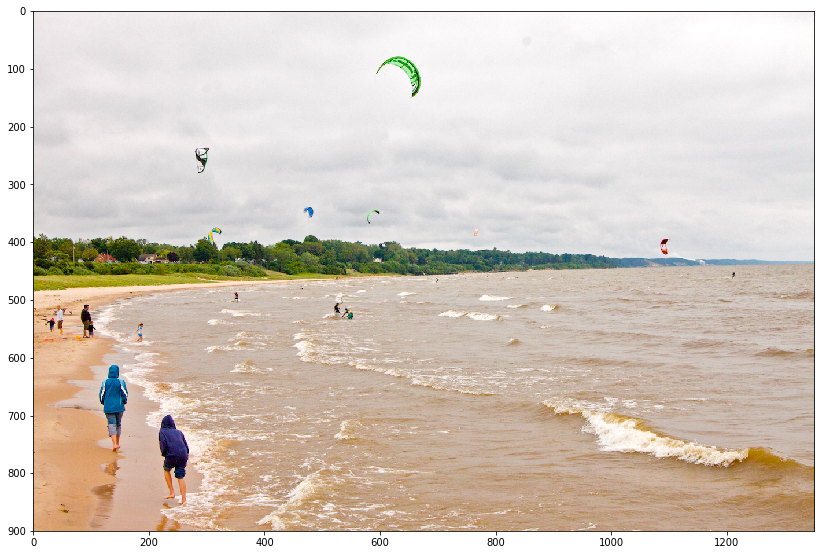

In [8]:
img_path = '../../sample_images/beach.jpg'
img = read_img(img_path)
height, width, _ = img.shape
plt.imshow(img)

### Running inference

In [9]:
%%time
img = Image.open(img_path)
img = image_to_nparray(img)
img = np.expand_dims(img, axis=0)
output_dict = run_inference_for_single_image(img, detection_graph)

CPU times: user 4.87 s, sys: 176 ms, total: 5.05 s
Wall time: 4.66 s


### Plots detections
Using the `confidence_threshold`

person
kite
person
kite


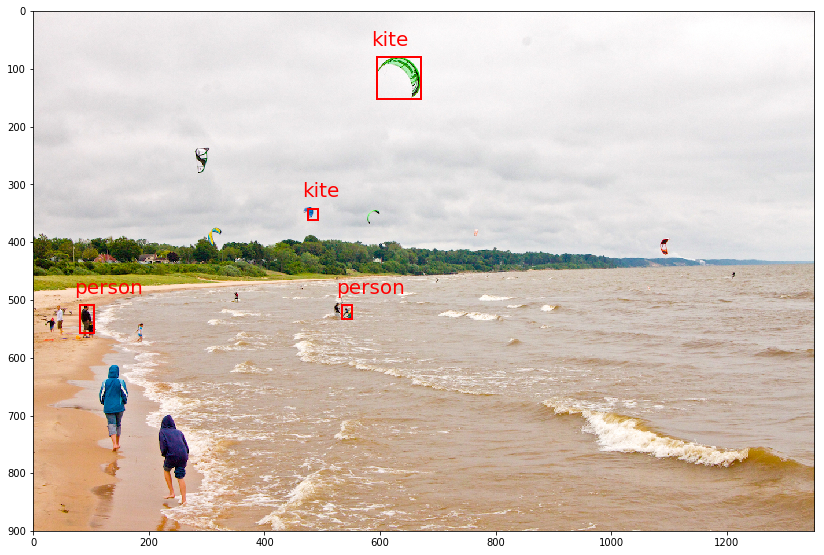

In [11]:
fig, ax = plt.subplots(1)
img = read_img(img_path)
confidence_threshold = .8

for boxes, score, cls_id in zip(output_dict['detection_boxes'],
                                output_dict['detection_scores'],
                                output_dict['detection_classes']):
    ymin, xmin, ymax, xmax = boxes
    if score > confidence_threshold:
        (left, right, top, bottom) = (xmin * width, xmax * width,
                                      ymin * height, ymax * height)
        rect = patches.Rectangle((left, top),
                                 right-left,
                                 bottom-top,
                                 linewidth=2, edgecolor='r',
                                 facecolor='none')
        ax.add_patch(rect)
        plt.text(left-10, top-20, labels_dict[cls_id], fontsize=20, color='r')
        print(labels_dict[cls_id])
ax.imshow(img)